<a href="https://colab.research.google.com/github/Pathet1cS/Predicting-CS-Student-Carrer/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

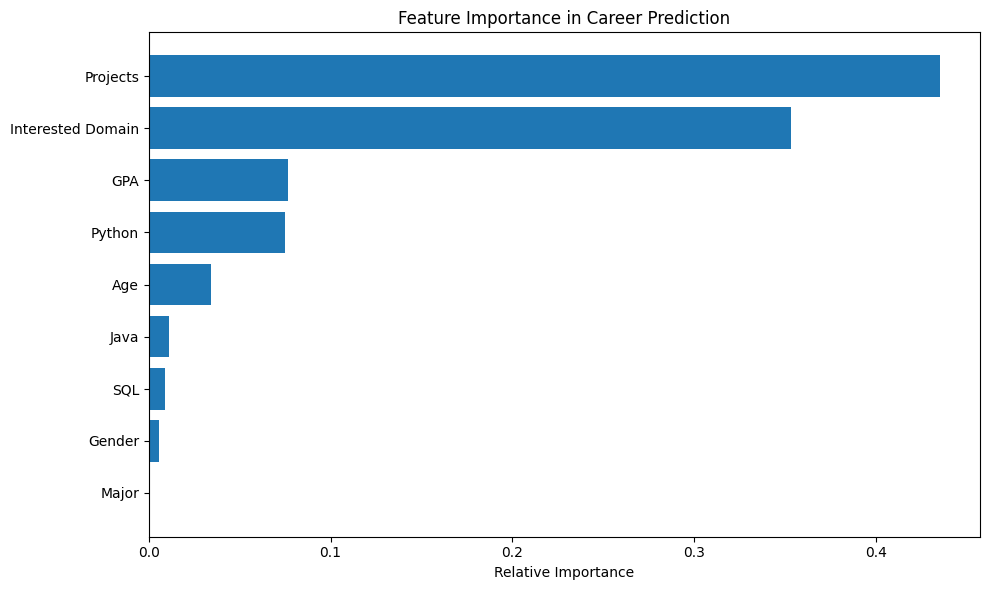


Accuracy: 0.83


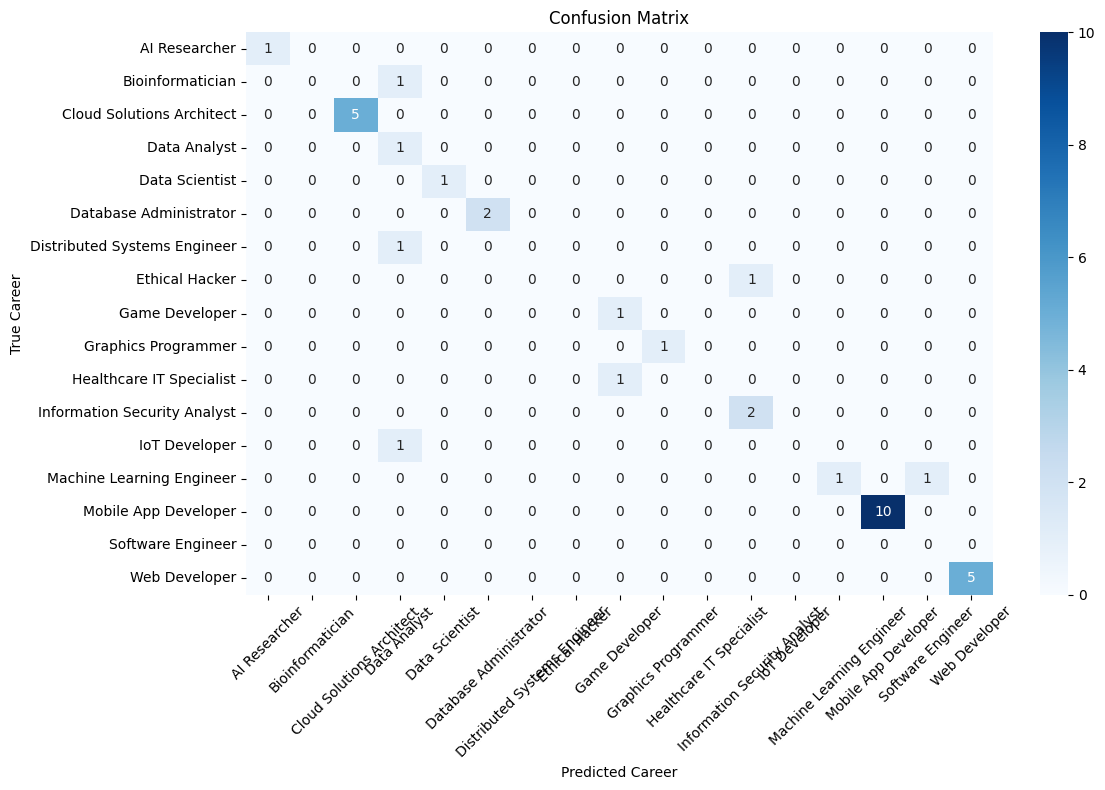


Detailed Metrics:

Career: AI Researcher
Precision: 1.00
Count: 1

Career: Bioinformatician
Precision: 0.00
Count: 1

Career: Cloud Solutions Architect
Precision: 1.00
Count: 5

Career: Data Analyst
Precision: 1.00
Count: 1

Career: Data Scientist
Precision: 1.00
Count: 1

Career: Database Administrator
Precision: 1.00
Count: 2

Career: Distributed Systems Engineer
Precision: 0.00
Count: 1

Career: Ethical Hacker
Precision: 0.00
Count: 1

Career: Game Developer
Precision: 1.00
Count: 1

Career: Graphics Programmer
Precision: 1.00
Count: 1

Career: Healthcare IT Specialist
Precision: 0.00
Count: 1

Career: Information Security Analyst
Precision: 1.00
Count: 2

Career: IoT Developer
Precision: 0.00
Count: 1

Career: Machine Learning Engineer
Precision: 0.50
Count: 2

Career: Mobile App Developer
Precision: 1.00
Count: 10

Career: Web Developer
Precision: 1.00
Count: 5

Predicted Career Path: Data Analyst


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class CSCareerPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.model = GaussianNB()

    def clean_data(self, df):
        """
        Clean the data before preprocessing
        """
        cleaned_df = df.copy()

        # Convert proficiency levels to numerical values
        proficiency_mapping = {
            'Weak': 1,
            'Average': 2,
            'Strong': 3
        }

        # Clean programming language proficiency columns
        for col in ['Python', 'SQL', 'Java']:
            if cleaned_df[col].dtype == 'object':
                cleaned_df[col] = cleaned_df[col].map(proficiency_mapping)
                # Fill any missing values with median
                cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].median())

        # Ensure GPA is numeric
        cleaned_df['GPA'] = pd.to_numeric(cleaned_df['GPA'], errors='coerce')
        cleaned_df['GPA'] = cleaned_df['GPA'].fillna(cleaned_df['GPA'].median())

        # Ensure Age is numeric
        cleaned_df['Age'] = pd.to_numeric(cleaned_df['Age'], errors='coerce')
        cleaned_df['Age'] = cleaned_df['Age'].fillna(cleaned_df['Age'].median())

        return cleaned_df

    def preprocess_data(self, df):
        """
        Preprocess the CS student dataset
        """
        # First clean the data
        cleaned_df = self.clean_data(df)

        # Make a copy to avoid modifying original data
        processed_df = cleaned_df.copy()

        # Drop non-predictive columns
        if 'Student ID' in processed_df.columns:
            processed_df.drop(['Student ID', 'Name'], axis=1, inplace=True)

        # Encode categorical variables
        categorical_columns = ['Gender', 'Major', 'Interested Domain', 'Projects']
        for column in categorical_columns:
            if column in processed_df.columns:
                self.label_encoders[column] = LabelEncoder()
                processed_df[column] = self.label_encoders[column].fit_transform(processed_df[column])

        # Scale numerical variables
        numerical_columns = ['Age', 'GPA', 'Python', 'SQL', 'Java']
        numerical_data = processed_df[numerical_columns]
        processed_df[numerical_columns] = self.scaler.fit_transform(numerical_data)

        # Encode target variable
        self.label_encoders['Future Career'] = LabelEncoder()
        processed_df['Future Career'] = self.label_encoders['Future Career'].fit_transform(processed_df['Future Career'])

        return processed_df

    def train(self, X, y):
        """
        Train the Naive Bayes model
        """
        self.model.fit(X, y)

    def predict(self, X):
        """
        Make predictions for new data
        """
        # Clean and preprocess the new data
        X_cleaned = self.clean_data(X)

        # Encode categorical variables
        categorical_columns = ['Gender', 'Major', 'Interested Domain', 'Projects']
        for column in categorical_columns:
            if column in X_cleaned.columns and column in self.label_encoders:
                X_cleaned[column] = self.label_encoders[column].transform(X_cleaned[column])

        # Scale numerical features
        numerical_columns = ['Age', 'GPA', 'Python', 'SQL', 'Java']
        X_cleaned[numerical_columns] = self.scaler.transform(X_cleaned[numerical_columns])

        predictions = self.model.predict(X_cleaned)
        return self.label_encoders['Future Career'].inverse_transform(predictions)

    def get_feature_importance(self, X, y):
        """
        Calculate feature importance using class conditional probabilities
        """
        feature_importance = {}
        classes = np.unique(y)

        for feature in X.columns:
            importance = np.abs(np.mean([
                np.mean(X[feature][y == c]) - np.mean(X[feature])
                for c in classes
            ]))
            feature_importance[feature] = importance

        # Normalize importance scores
        total = sum(feature_importance.values())
        feature_importance = {k: v/total for k, v in feature_importance.items()}

        return feature_importance

    def plot_feature_importance(self, feature_importance):
        """
        Plot feature importance
        """
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': feature_importance.keys(),
            'Importance': feature_importance.values()
        }).sort_values('Importance', ascending=True)

        plt.barh(importance_df['Feature'], importance_df['Importance'])
        plt.title('Feature Importance in Career Prediction')
        plt.xlabel('Relative Importance')
        plt.tight_layout()
        plt.show()

    def evaluate(self, X_test, y_test):
        """
        Evaluate the model and display metrics
        """
        predictions = self.model.predict(X_test)
        y_test_labels = self.label_encoders['Future Career'].inverse_transform(y_test)
        pred_labels = self.label_encoders['Future Career'].inverse_transform(predictions)

        # Calculate accuracy
        accuracy = np.mean(y_test_labels == pred_labels)
        print(f"\nAccuracy: {accuracy:.2f}")

        # Create confusion matrix
        unique_labels = np.unique(np.concatenate([y_test_labels, pred_labels]))
        cm = confusion_matrix(y_test_labels, pred_labels, labels=unique_labels)

        # Plot confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=unique_labels,
                   yticklabels=unique_labels)
        plt.title('Confusion Matrix')
        plt.ylabel('True Career')
        plt.xlabel('Predicted Career')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Print classification metrics
        print("\nDetailed Metrics:")
        for label in unique_labels:
            mask = y_test_labels == label
            correct = pred_labels[mask] == label
            if len(correct) > 0:
                precision = np.mean(correct)
                print(f"\nCareer: {label}")
                print(f"Precision: {precision:.2f}")
                print(f"Count: {len(correct)}")

def main():
    # Load your dataset
    df = pd.read_csv('your_dataset')

    # Initialize predictor
    predictor = CSCareerPredictor()

    # Preprocess data
    processed_df = predictor.preprocess_data(df)

    # Split features and target
    X = processed_df.drop('Future Career', axis=1)
    y = processed_df['Future Career']

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    predictor.train(X_train, y_train)

    # Calculate and plot feature importance
    feature_importance = predictor.get_feature_importance(X_train, y_train)
    predictor.plot_feature_importance(feature_importance)

    # Evaluate model
    predictor.evaluate(X_test, y_test)

    new_student = pd.DataFrame({
    'Gender': ['Male'],
    'Age': [21],
    'GPA': [3.7],
    'Major': ['Computer Science'],
    'Interested Domain': ['Machine Learning'],
    'Projects': ['Image Recognition'],
    'Python': ['Strong'],
    'SQL': ['Average'],
    'Java': ['Weak']
    })

    predicted_career = predictor.predict(new_student)
    print("\nPredicted Career Path:", predicted_career[0])

if __name__ == "__main__":
    main()